# Librairie nécessaire pour l'analyse et le nettoyage des données

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Analyse sur les données du Coronavirus

In [0]:
data = pd.read_json("https://pomber.github.io/covid19/timeseries.json")

#données sous format JSON
data.head()

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Brazil,Brunei,Bulgaria,Burkina Faso,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Congo (Brazzaville),Congo (Kinshasa),Costa Rica,Cote d'Ivoire,Croatia,Diamond Princess,...,Togo,Trinidad and Tobago,Tunisia,Turkey,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,US,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe,Dominica,Grenada,Mozambique,Syria,Timor-Leste,Belize,Laos,Libya,West Bank and Gaza,Guinea-Bissau,Mali,Saint Kitts and Nevis,Kosovo,Burma,MS Zaandam,Botswana,Burundi,Sierra Leone,Malawi,South Sudan,Western Sahara,Sao Tome and Principe,Yemen,Comoros,Tajikistan
0,"{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 548, 'death...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...",...,"{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 1, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'

In [0]:
##################################################################################
## Génaration des Tables pour chaques pays avec Cas Confirmés, soignés et décès ##
##################################################################################

# choix des pays pour la regréssion

list_country = []

list_df = {}

for country in data.columns:
  list_country.append(country)

listpays = []
#possible de faire pour tous les pays si besoin
def agregateDataByCountry(country, numberCase):
    dataDate = []
    dataConfirmed = []
    dataDeath = []
    dataRecovered = []
    for i in range(len(data[country])):
      if data[country][i]["confirmed"] >= numberCase:
        dataDate.append(data[country][i]["date"])
        dataConfirmed.append(data[country][i]["confirmed"])
        dataDeath.append(data[country][i]["deaths"])
        dataRecovered.append(data[country][i]["recovered"])

    global countryDf
    countryDf = pd.DataFrame({
        "Date": dataDate,
        "Confirmed": dataConfirmed,
        "Death": dataDeath,
        "Recovered": dataRecovered
    })
    
    return country

#stocker les dataFrame dans un dictionnaire
for country in list_country:
  #choisir le pays et le nombre de cas confirmés
    agregateDataByCountry(country,1000)
    list_df[country] = countryDf
    list_df[country]['Date'] = pd.to_datetime(list_df[country]['Date'], dayfirst = False, yearfirst = False)
    
#il reste plus qu'à les sortir en excel pour faire graphe ou agréger les données budget santé/ démocracy Index / population
def createActiveCase():
  for country in list_country:
    # nombre cas contaminés encore actif
    list_df[country]["Active"] = list_df[country]["Confirmed"] - list_df[country]["Death"] - list_df[country]["Recovered"]

    #Growth factor de cas actif => permet de trouver le point d'inflection et de savoir quand la situation se retrourne
    #attention car si diviser par 0 => pas possible et ça crée des beugs
    list_df[country]["GrowthFactorActive"] = list_df[country]["Active"].shift(1, axis=0)/list_df[country]["Active"].shift(2, axis=0)

    #le logarithme du nombre de cas actif
    list_df[country]["LogActive"] = np.log(list_df[country]["Active"])
    list_df[country]["LogConfirmed"] = np.log(list_df[country]["Confirmed"])
    list_df[country]["LogDeath"] = np.log(list_df[country]["Death"])
    list_df[country]["LogRecovered"] = np.log(list_df[country]["Recovered"])

    #taux de croissance du nombre de cas actif et de décès
    list_df[country]["GrowthRateActive"] = list_df[country]["LogActive"] - list_df[country]["LogActive"].shift(1)
    list_df[country]["GrowthRateDeath"] = (np.log(list_df[country]["Death"])) - (np.log(list_df[country]["Death"].shift(1)))

    #taux de personnes soignés et de mortalité par rapport aux nombre de cas confirmés
    list_df[country]["MortalityRate"] = np.round(100*list_df[country]["Death"]/list_df[country]["Confirmed"],2)
    list_df[country]["RecoveredRate"] = np.round(100*list_df[country]["Recovered"]/list_df[country]["Confirmed"],2)

    ## formule %change => (n - (n-1))/(n-1) ## => % de variation pour décès, personnes soignés et cas actif
    list_df[country]["DeathVariation"] = list_df[country]['Death'].pct_change()
    list_df[country]["RecoveredVariation"] = list_df[country]['Recovered'].pct_change()
    list_df[country]["ActiveVariation"] = list_df[country]['Active'].pct_change()


createActiveCase() 

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [0]:

dataCountry = []
dataDeath = []
dataDeathValueCountry = []
dataDeathValue = []
for country in list_country:
  dataCountry.append(country)
  dataDeath.append(list_df[country]["Death"])

for i in range(len(dataDeath)):
  if dataDeath[i].empty == True:
    dataDeathValueCountry.append(0)
  else:
    for value in dataDeath[i].values:
      dataDeathValueCountry.append(value)

  dataDeathValue.append(dataDeathValueCountry)
  dataDeathValueCountry = []

dfTest = []
for i in range(len(dataCountry)):
  df = pd.DataFrame(dataDeathValue[i],columns= [dataCountry[i]])
  dfTest.append(df)

dfConcatDeath = pd.concat(dfTest, axis=1)
dfConcatDeath = dfConcatDeath.transpose()
dfConcatDeath.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102
Afghanistan,36.0,36.0,40.0,42.0,43.0,47.0,50.0,57.0,58.0,60.0,64.0,68.0,72.0,85.0,90.0,95.0,104.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Albania,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Algeria,105.0,130.0,152.0,173.0,193.0,205.0,235.0,256.0,275.0,293.0,313.0,326.0,336.0,348.0,364.0,367.0,375.0,384.0,392.0,402.0,407.0,415.0,419.0,425.0,432.0,437.0,444.0,450.0,453.0,459.0,463.0,465.0,470.0,476.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Andorra,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Angola,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
dfConcatDeath.to_excel("Deaths.xlsx")

In [0]:
dfConcatDeath[30].sort_values().dropna().tail(20).plot.bar(title='Pays avec le plus du mort à 30jours', color='red')

KeyError: ignored

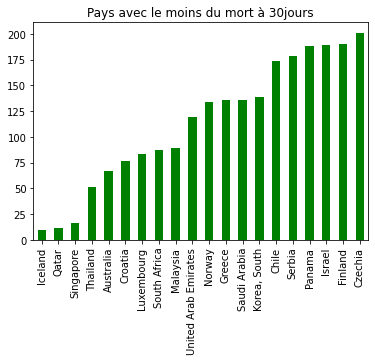

In [0]:
dfConcatDeath[30].sort_values().dropna().head(20).plot.bar(title='Pays avec le moins du mort à 30jours', color='green')

In [0]:
plt.figure()
dfConcatDeath = dfConcatDeath.transpose()
ax = dfConcatDeath["US"].plot.line(color='DarkBlue', label='US')
dfConcatDeath["Portugal"].plot.line(color='green', label='Portugal')
dfConcatDeath["France"].plot.line(color='yellow', label='France')
ax.legend()
plt.show()

KeyError: ignored

<Figure size 432x288 with 0 Axes>

# Graphe pour comprendre l'évolution du Coronavirus

In [0]:
########################################
## Fonction pour faire les graphiques ##
########################################
"""
country : choisir le nom du pays pour avoir les 4 graphes
"""

def doingGraph(country):
  plt.figure()
  list_df[country].plot(kind='line',x='Date',y='Confirmed',color='red', title=country)
  list_df[country].plot(kind='line',x='Date',y='Death',color='blue', title=country)
  list_df[country].plot(kind='line',x='Date',y='Recovered',color='green', title=country)
  list_df[country].plot(kind='line',x='Date',y='Active',color='black', title=country)
  plt.show()

def doingGraphVariation(country):
  plt.figure()
  list_df[country].plot(kind='line',x='Date',y="DeathVariation",color='red', title=country)
  list_df[country].plot(kind='line',x='Date',y="RecoveredVariation",color='blue', title=country)
  list_df[country].plot(kind='line',x='Date',y="ActiveVariation",color='green', title=country)
  plt.show()

<Figure size 432x288 with 0 Axes>

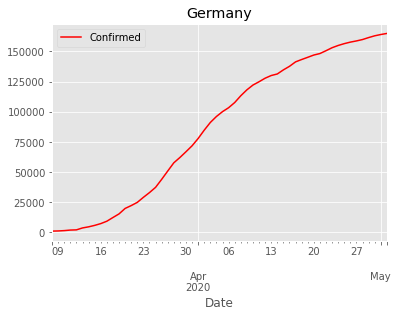

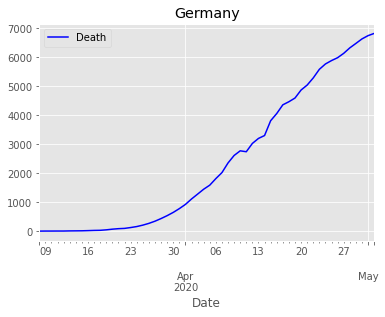

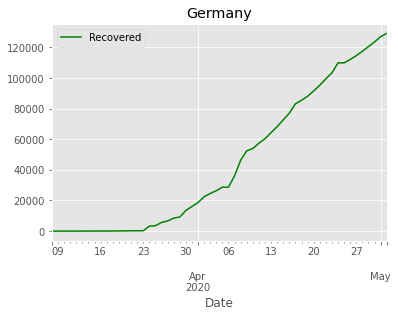

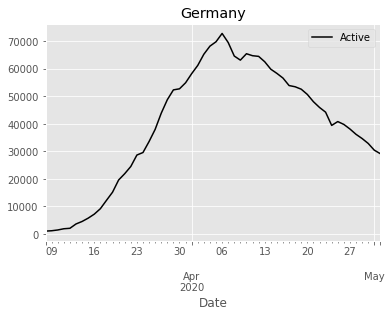

In [0]:
doingGraph('Germany')

<Figure size 432x288 with 0 Axes>

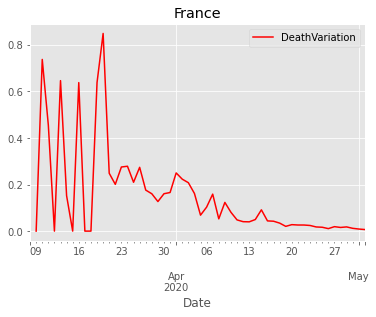

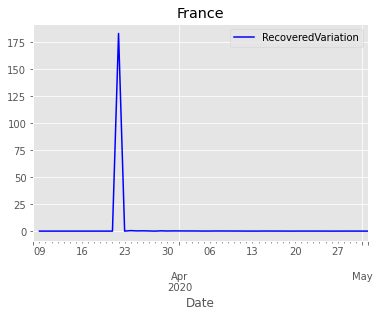

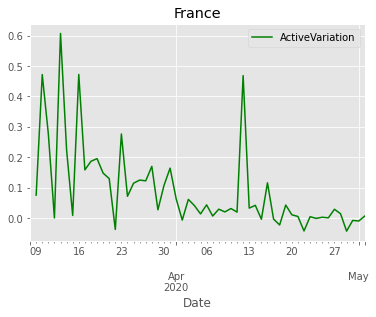

In [0]:
doingGraphVariation("France")

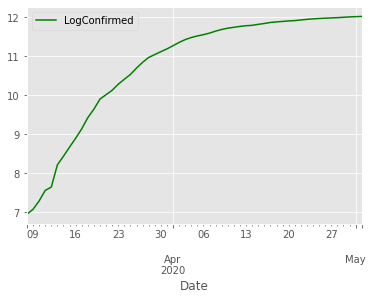

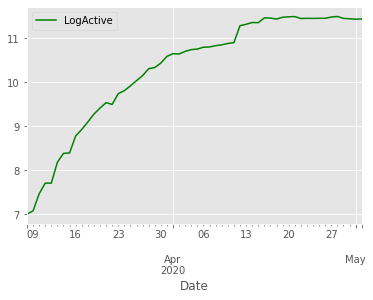

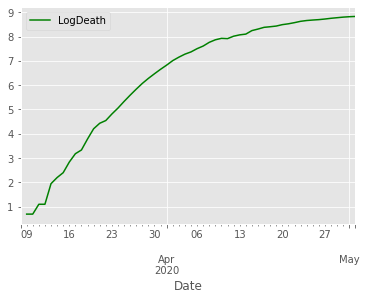

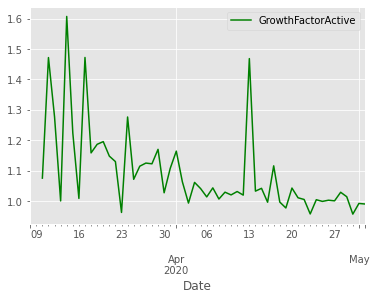

In [0]:
list_df["Germany"].plot(kind='line',x='Date',y="LogConfirmed",color='green')
list_df["France"].plot(kind='line',x='Date',y="LogActive",color='green')
list_df["Germany"].plot(kind='line',x='Date',y="LogDeath",color='green')
list_df["France"].plot(kind='line',x='Date',y="GrowthFactorActive",color='green')
plt.show()

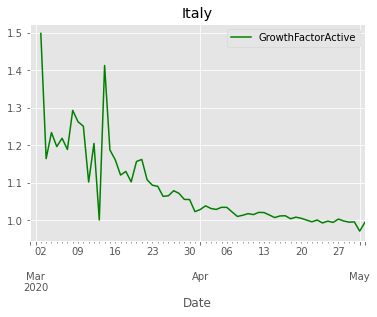

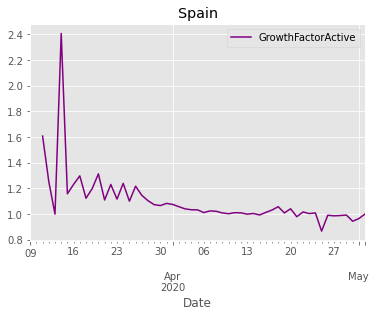

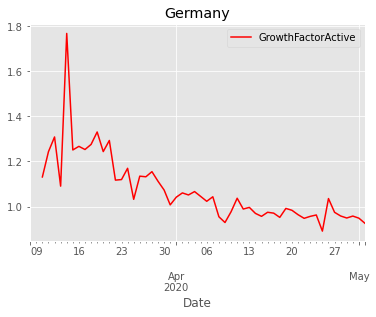

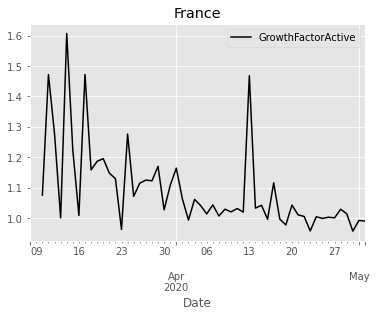

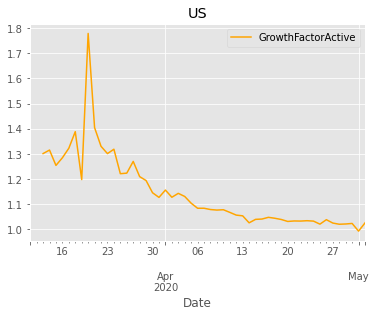

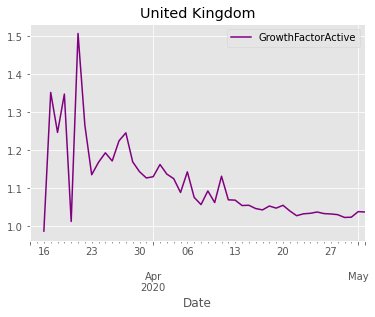

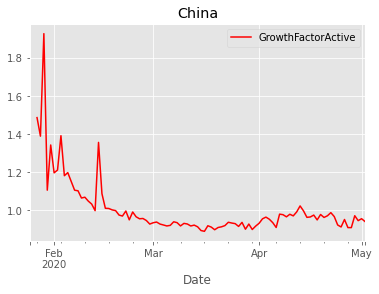

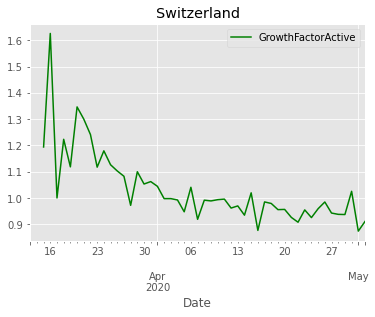

In [0]:
list_df["Italy"].plot(kind='line',x='Date',y="GrowthFactorActive",color='green',title = "Italy")
list_df["Spain"].plot(kind='line',x='Date',y="GrowthFactorActive",color='purple',title = "Spain")
list_df["Germany"].plot(kind='line',x='Date',y="GrowthFactorActive",color='red',title = "Germany")
list_df["France"].plot(kind='line',x='Date',y="GrowthFactorActive",color='black',title = "France")
list_df["US"].plot(kind='line',x='Date',y="GrowthFactorActive",color='orange',title = "US")
list_df["United Kingdom"].plot(kind='line',x='Date',y="GrowthFactorActive",color='purple',title = "United Kingdom")
list_df["China"].plot(kind='line',x='Date',y="GrowthFactorActive",color='red',title = "China")
list_df["Switzerland"].plot(kind='line',x='Date',y="GrowthFactorActive",color='green',title = "Switzerland")
plt.show()

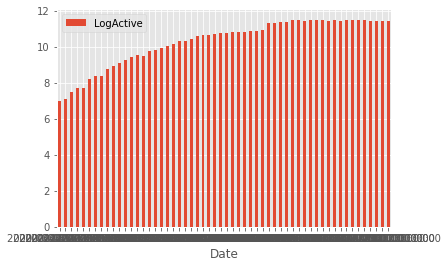

In [0]:
list_df['France'].plot.bar(x='Date',y='LogActive',rot=0)

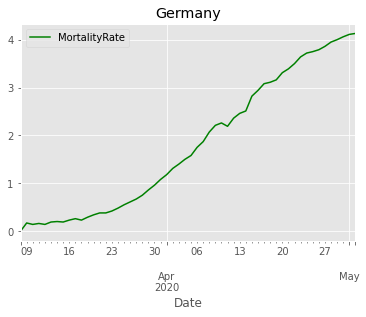

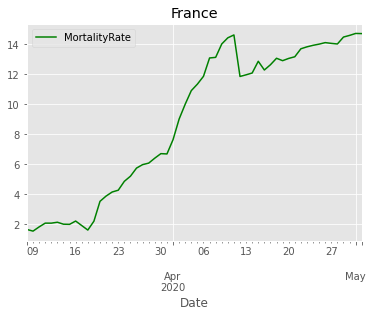

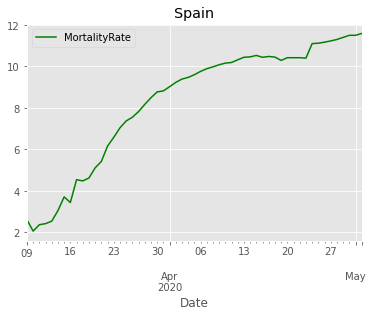

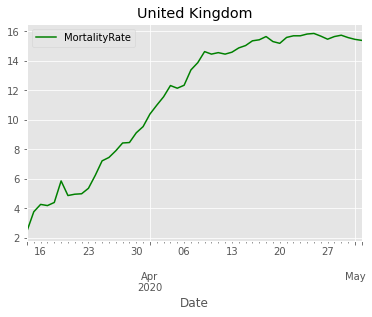

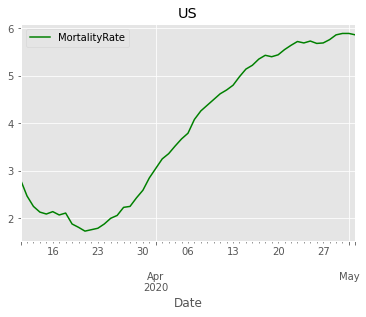

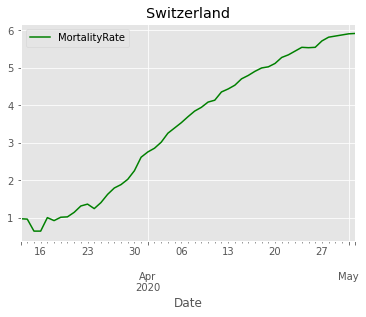

In [0]:
list_df["Germany"].plot(kind='line',x='Date',y="MortalityRate",color='green', title= "Germany")
list_df["France"].plot(kind='line',x='Date',y="MortalityRate",color='green', title="France")
list_df["Spain"].plot(kind='line',x='Date',y="MortalityRate",color='green', title= "Spain")
list_df["United Kingdom"].plot(kind='line',x='Date',y="MortalityRate",color='green', title="United Kingdom")
list_df["US"].plot(kind='line',x='Date',y="MortalityRate",color='green', title="US")
list_df["Switzerland"].plot(kind='line',x='Date',y="MortalityRate",color='green', title="Switzerland")
plt.show()

In [0]:
list_df['United Kingdom'].Confirmed

0       1144
1       1145
2       1551
3       1960
4       2642
5       2716
6       4014
7       5067
8       5745
9       6726
10      8164
11      9640
12     11812
13     14745
14     17312
15     19780
16     22453
17     25481
18     29865
19     34173
20     38689
21     42477
22     48436
23     52279
24     55949
25     61474
26     65872
27     74605
28     79874
29     85206
30     89570
31     94845
32     99483
33    104145
34    109769
35    115314
36    121172
37    125856
38    130172
39    134638
40    139246
41    144640
42    149569
43    154037
44    158348
45    162350
46    166441
47    172481
48    178685
49    183500
Name: Confirmed, dtype: int64

In [0]:
list_df['United Kingdom'].Death

0        28
1        43
2        66
3        82
4       116
5       159
6       195
7       251
8       286
9       360
10      509
11      695
12      879
13     1163
14     1457
15     1672
16     2046
17     2429
18     3100
19     3752
20     4467
21     5228
22     5874
23     6445
24     7483
25     8519
26     9623
27    10776
28    11616
29    12302
30    13047
31    14095
32    14941
33    15974
34    16910
35    18028
36    18527
37    19092
38    20264
39    21111
40    21840
41    22853
42    23697
43    24117
44    24458
45    25369
46    26166
47    26842
48    27583
49    28205
Name: Death, dtype: int64

# Nettoyage des données pour le démocracy Index

In [0]:
# données sur le Democracy Index
dataDemo = pd.read_excel("https://github.com/GuillaumePv/Covid-19/blob/master/_EIU-Democracy%20Indices%20-%20Dataset%20-%20v3-2.xlsx?raw=true", sheet_name="data-for-countries-etc-by-year")
dataDemo.head()

,geo,name,time,Democracy index (EIU),Electoral pluralism index (EIU),Government index (EIU),Political participation index(EIU),Political culture index (EIU),Civil liberties index (EIU),Change in democracy index (EIU)
0,afg,Afghanistan,2006,30.6,61.70,0.00,22.2,25.0,44.10,NaN
1,afg,Afghanistan,2007,30.4,56.70,3.95,22.2,25.0,44.10,-0.2
2,afg,Afghanistan,2008,30.2,51.70,7.90,22.2,25.0,44.10,-0.2
3,afg,Afghanistan,2009,27.5,38.35,7.90,25.0,25.0,41.15,-2.7
4,afg,Afghanistan,2010,24.8,25.00,7.90,27.8,25.0,38.20,-2.7


In [0]:
#agregation des données du démocracy index

countryDemo = dataDemo.groupby('name')
dataDemo = dataDemo.drop(dataDemo.iloc[:,4:],axis=1)
indexNames = dataDemo[ dataDemo['time'] != 2019 ].index
dataDemo = dataDemo.drop(indexNames,axis=0)
dataDemo.head()

,geo,name,time,Democracy index (EIU)
13,afg,Afghanistan,2019,28.5
27,alb,Albania,2019,58.9
41,dza,Algeria,2019,40.1
55,ago,Angola,2019,37.2
69,arg,Argentina,2019,70.2


Text(0.5, 0, 'Country')

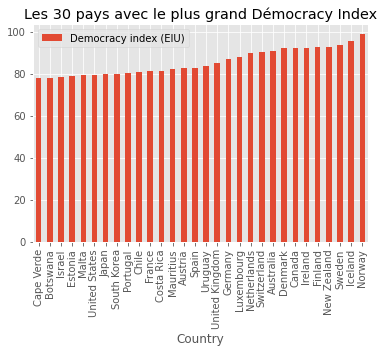

In [0]:
ax = dataDemo.sort_values('Democracy index (EIU)').tail(30).plot.bar(x="name",y='Democracy index (EIU)', title="Les 30 pays avec le plus grand Démocracy Index")
ax.set_xlabel('Country')

# Nettoyage des données pour les dépenses santés

In [0]:
# données budget santé (% du GDP) par pays
dataBudgetHealth = pd.read_excel("https://github.com/GuillaumePv/Covid-19/blob/master/NHA%20indicators.xlsx?raw=true")

#enlever les colonnes inutiles
dataBudgetHealth = dataBudgetHealth.drop(dataBudgetHealth.iloc[:,2:20],axis=1)
dataBudgetHealth = dataBudgetHealth.dropna()
dataBudgetHealth.head()

###############
## Attention ##
###############
#il y des valeurs manquantes


,Countries,Indicators,2017
1,Algeria,Current Health Expenditure (CHE) as % Gross Do...,6.37432
2,Angola,Current Health Expenditure (CHE) as % Gross Do...,2.7915
3,Benin,Current Health Expenditure (CHE) as % Gross Do...,3.71858
4,Botswana,Current Health Expenditure (CHE) as % Gross Do...,6.13457
5,Burkina Faso,Current Health Expenditure (CHE) as % Gross Do...,6.91506


# Nettoyage pour l'ouverture du pays

In [0]:
dataOpeness = pd.read_excel("https://github.com/GuillaumePv/Covid-19/blob/master/kaopen_2017.xls?raw=true")

In [0]:
dataOpeness.head()

,cn,ccode,country_name,year,kaopen,ka_open
0,111,USA,United States,1970,2.346708,1.0
1,111,USA,United States,1971,2.346708,1.0
2,111,USA,United States,1972,2.346708,1.0
3,111,USA,United States,1973,2.346708,1.0
4,111,USA,United States,1974,2.346708,1.0


In [0]:
indexYear = dataOpeness[ dataOpeness['year'] != 2017 ].index
dataOpeness = dataOpeness.drop(indexYear, axis=0)
dataOpeness = dataOpeness.drop(["cn"],axis=1)
dataOpeness.head()

,ccode,country_name,year,kaopen,ka_open
47,USA,United States,2017,2.346708,1.0
95,GBR,United Kingdom,2017,2.346708,1.0
143,AUT,Austria,2017,2.346708,1.0
191,BEL,Belgium,2017,2.346708,1.0
239,DNK,Denmark,2017,2.346708,1.0


# Nettoyage pour data Individualisme

In [0]:
dataInd = pd.read_excel("https://github.com/GuillaumePv/Covid-19/blob/master/6-dimensions-for-website-2015-08-16%20(1).xls?raw=true")
dataInd.head()

,ctr,country,pdi,idv,mas,uai,ltowvs,ivr
0,AFE,Africa East,64.0,27.0,41.0,52.0,32.000000,40.000000
1,AFW,Africa West,77.0,20.0,46.0,54.0,9.000000,78.000000
2,ALB,Albania,NaN,NaN,NaN,NaN,61.460957,14.508929
3,ALG,Algeria,NaN,NaN,NaN,NaN,25.944584,32.366071
4,AND,Andorra,NaN,NaN,NaN,NaN,NaN,65.000000


In [0]:
#enlever les colonnes non nécessaire 
dataInd = dataInd.drop(['pdi'],axis=1)
dataInd = dataInd.drop(['mas'],axis=1)
dataInd = dataInd.drop(['uai'],axis=1)
dataInd = dataInd.drop(['ltowvs'],axis=1)
dataInd = dataInd.drop(['ivr'],axis=1)

#enlever les pays avec pas d'indice d'individualisme
dataInd = dataInd.dropna()

dataInd.head()

,ctr,country,idv
0,AFE,Africa East,27.0
1,AFW,Africa West,20.0
5,ARA,Arab countries,38.0
6,ARG,Argentina,46.0
8,AUL,Australia,90.0


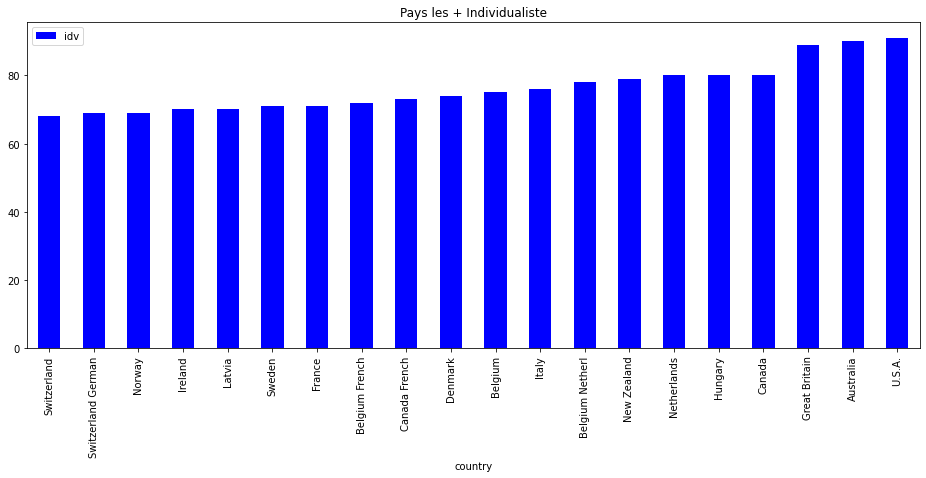

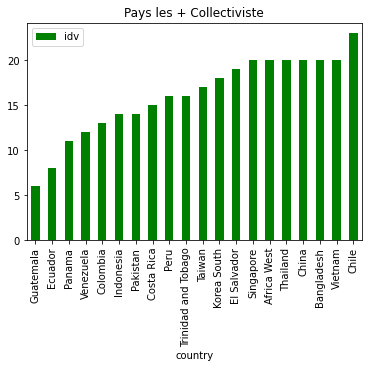

In [0]:

dataIndSortTail = dataInd.sort_values('idv').tail(20)
ax = dataIndSortTail.plot.bar(x='country',title="Pays les + Individualiste",color="blue",figsize=(16,6))
plt.savefig('image.jpg')

dataIndSortHead = dataInd.sort_values('idv').head(20)
dataIndSortHead.plot.bar(x='country',title="Pays les + Collectiviste",color="green")
plt.savefig('image2.jpg')

In [0]:
dataIndSortTail

,ctr,country,idv
95,SWI,Switzerland,68.0
97,SWG,Switzerland German,69.0
74,NOR,Norway,69.0
52,IRE,Ireland,70.0
60,LAT,Latvia,70.0
94,SWE,Sweden,71.0
37,FRA,France,71.0
14,BEF,Belgium French,72.0
21,CAF,Canada French,73.0
29,DEN,Denmark,74.0


**Export sour format excel**

# Nettoyage du GDP per Capital

In [0]:
dataGDP = pd.read_excel("https://github.com/GuillaumePv/Covid-19/blob/master/API_NY.GDP.PCAP.CD_DS2_en_excel_v2_988388.xls?raw=true",sheet_name="Data")

In [0]:
dataGDP = dataGDP.drop(dataGDP.iloc[:,4:61],axis=1)
dataGDP = dataGDP.drop(['Unnamed: 63'],axis=1)
dataGDP = dataGDP.drop([0,1])
dataGDP.head()


,Data Source,World Development Indicators,Unnamed: 2,Unnamed: 3,Unnamed: 61,Unnamed: 62
2,Country Name,Country Code,Indicator Name,Indicator Code,2017.000000,2018.000000
3,Aruba,ABW,GDP per capita (current US$),NY.GDP.PCAP.CD,25630.266492,NaN
4,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,556.302139,520.896603
5,Angola,AGO,GDP per capita (current US$),NY.GDP.PCAP.CD,4095.812942,3432.385736
6,Albania,ALB,GDP per capita (current US$),NY.GDP.PCAP.CD,4532.890162,5268.848504


# Nettoyage pour le testing Coronavirus

In [0]:
dataTesting = pd.read_excel("https://github.com/owid/covid-19-data/blob/master/public/data/testing/covid-testing-all-observations.xlsx?raw=true")
dataTesting.head()
with pd.ExcelWriter('CleaningDataTesting.xlsx') as writer:
  dataTesting.to_excel(writer,sheet_name="TestCoronavirus")

# Nettoyage des données sur la population (nombre, densité, âge median, migration)

Densité de la population

In [0]:
dataDensity = pd.read_excel("https://github.com/GuillaumePv/Covid-19/blob/master/WPP2019_POP_F06_POPULATION_DENSITY.xlsx?raw=true", sheet_name="ESTIMATES")
dataDensity.head()

In [0]:
dataDensity = dataDensity.drop(dataDensity.iloc[:,6:77], axis=1)
dataDensity = dataDensity.drop(['Unnamed: 0'], axis=1)
dataDensity = dataDensity.drop(['Unnamed: 1'], axis=1)
dataDensity = dataDensity.drop(['Unnamed: 3'], axis=1)
dataDensity = dataDensity.drop(['Unnamed: 4'], axis=1)
dataDensity = dataDensity.dropna()
dataDensity = dataDensity.reset_index(drop=True)
for i in range(1,25):
  dataDensity = dataDensity.drop(i)
dataDensity = dataDensity.reset_index(drop=True)

dataDensity.columns = dataDensity.iloc[0]
dataDensity = dataDensity[1:]

dataDensity.head()

Flux de migration par pays (à finir)

In [0]:
dataMigration = pd.read_excel("https://github.com/GuillaumePv/Covid-19/blob/master/WPP2019_MIGR_F01_NET_MIGRATION_RATE.xlsx?raw=true")
dataMigration.head()

In [0]:
dataMigration = dataMigration.drop(['Unnamed: 0'], axis=1)
dataMigration = dataMigration.drop(['Unnamed: 1'], axis=1)
dataMigration = dataMigration.drop(['Unnamed: 3'], axis=1)
dataMigration = dataMigration.drop(['Unnamed: 4'], axis=1)
dataMigration = dataMigration.dropna()
dataMigration = dataMigration.reset_index(drop=True)

for i in range(1,25):
  dataMigration = dataMigration.drop(i)
dataMigration = dataMigration.reset_index(drop=True)

dataMigration.columns = dataMigration.iloc[0]
dataMigration = dataMigration[1:]
dataMigration = dataMigration.drop(dataMigration.iloc[:,2:16], axis=1)
dataMigration.head()

Age médian de la population par pays


In [0]:
dataAge = pd.read_excel("https://github.com/GuillaumePv/Covid-19/blob/master/WPP2019_POP_F05_MEDIAN_AGE.xlsx?raw=true", sheet_name="ESTIMATES")
dataAge.head()

In [0]:
dataAge = dataAge.drop(['Unnamed: 0'], axis=1)
dataAge = dataAge.drop(['Unnamed: 1'], axis=1)
dataAge = dataAge.drop(['Unnamed: 3'], axis=1)
dataAge = dataAge.drop(['Unnamed: 4'], axis=1)
dataAge = dataAge.drop(dataAge.iloc[:,3:15], axis=1)
dataAge = dataAge.drop(['Unnamed: 6'], axis=1)
dataAge = dataAge.dropna()
dataAge = dataAge.reset_index(drop=True)

for i in range(1,25):
  dataAge = dataAge.drop(i)
dataAge = dataAge.reset_index(drop=True)

dataAge.columns = dataAge.iloc[0]
dataAge = dataAge[1:]
dataAge = dataAge.drop(['2010'], axis=1)
dataAge = dataAge.drop(['2015'], axis=1)

dataAge.head()

Nombre total population par pays

In [0]:
dataPop =  pd.read_excel("https://github.com/GuillaumePv/Covid-19/blob/master/WPP2019_POP_F01_1_TOTAL_POPULATION_BOTH_SEXES.xlsx?raw=true", sheet_name="ESTIMATES")
dataPop.head()

In [0]:
dataPop = dataPop.drop(['Unnamed: 0'], axis=1)
dataPop = dataPop.drop(['Unnamed: 1'], axis=1)
dataPop = dataPop.drop(['Unnamed: 3'], axis=1)
dataPop = dataPop.drop(['Unnamed: 4'], axis=1)
dataPop = dataPop.drop(dataPop.iloc[:,3:73], axis=1)
dataPop = dataPop.dropna()
dataPop = dataPop.reset_index(drop=True)

for i in range(1,22):
  dataPop = dataPop.drop(i)
dataPop = dataPop.reset_index(drop=True)

dataPop.columns = dataPop.iloc[0]
dataPop = dataPop[1:]

dataPop.head()

In [0]:
with pd.ExcelWriter('CleaningData.xlsx') as writer:
  dfConcatDeath.to_excel(writer,sheet_name='DeathsAfter1000confirmed')
  dataDemo.to_excel(writer,sheet_name='DemocracyIndex')
  dataInd.to_excel(writer,sheet_name='CultureInd')
  dataOpeness.to_excel(writer,sheet_name='ouverturePays')
  dataBudgetHealth.to_excel(writer,sheet_name="BudgetSanté")
  dataTesting.to_excel(writer,sheet_name="TestCoronavirus")
  dataGDP.to_excel(writer,sheet_name="GDPperCapital")
  dataAge.to_excel(writer,sheet_name='Age')
  dataPop.to_excel(writer, sheet_name='Pop')
  dataMigration.to_excel(writer, sheet_name='Migration')
  dataDensity.to_excel(writer, sheet_name='Density')

Test sur réponse des gouvernements

In [0]:
dataResp = pd.read_csv("https://github.com/OxCGRT/covid-policy-tracker/blob/master/data/OxCGRT_latest.csv?raw=true")

dataResp.head()

In [0]:
print(dataResp)